In [1]:
# Import Necessary Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision  # Added for image grid visualization


# Set the device to mps or cuda
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

Using device:  mps


In [2]:
# Hyperparameters
learning_rate = 0.0005
batch_size = 256
num_epochs = 30
latent_dim = 256
beta = 0.9  # KL divergence scaling factor
seed = 42

# Network architecture
hidden_dims = [512, 256]  # Encoder and decoder hidden layer sizes

# Data augmentation (if any)
data_augmentation = False

# Random Seed for Reproducibility
torch.manual_seed(seed)

In [3]:
# Define data transformations
transform_list = [transforms.ToTensor()]

if data_augmentation:
    transform_list = [
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor()
    ]

transform = transforms.Compose(transform_list)

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class VAE(nn.Module):
    def __init__(self, hidden_dims, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        modules = []
        input_dim = 28 * 28
        for h_dim in hidden_dims:
            modules.append(nn.Linear(input_dim, h_dim))
            modules.append(nn.ReLU())
            input_dim = h_dim
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        modules = []
        hidden_dims.reverse()
        input_dim = latent_dim
        for h_dim in hidden_dims:
            modules.append(nn.Linear(input_dim, h_dim))
            modules.append(nn.ReLU())
            input_dim = h_dim
        modules.append(nn.Linear(hidden_dims[-1], 28 * 28))
        modules.append(nn.Sigmoid())  # Keep Sigmoid since input images are in [0,1]
        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [5]:
def loss_function(recon_x, x, mu, logvar, beta):
    # Reconstruction loss (Mean Squared Error)
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD


# Initialize the model
model = VAE(hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Visualize Reconstructions and Generated Images; Plot ELBO Loss and KL-divergence

In [6]:
train_losses = []
recon_losses = []
kld_losses = []

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    recon_loss_total = 0
    kld_loss_total = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        # Gradient clipping (optional)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kld_loss_total += kld_loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss_total / len(train_loader.dataset)
    avg_kld_loss = kld_loss_total / len(train_loader.dataset)
    train_losses.append(avg_loss)
    recon_losses.append(avg_recon_loss)
    kld_losses.append(avg_kld_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KLD: {avg_kld_loss:.4f}')


Epoch [1/30], Loss: 57.0172, Recon Loss: 55.9865, KLD: 1.1452
Epoch [2/30], Loss: 48.0682, Recon Loss: 45.7540, KLD: 2.5714
Epoch [3/30], Loss: 45.1953, Recon Loss: 41.1714, KLD: 4.4711
Epoch [4/30], Loss: 42.1294, Recon Loss: 36.4210, KLD: 6.3427
Epoch [5/30], Loss: 40.7250, Recon Loss: 34.1759, KLD: 7.2768
Epoch [6/30], Loss: 39.6951, Recon Loss: 32.6069, KLD: 7.8758
Epoch [7/30], Loss: 38.4775, Recon Loss: 30.9642, KLD: 8.3481
Epoch [8/30], Loss: 36.7474, Recon Loss: 29.0186, KLD: 8.5875
Epoch [9/30], Loss: 34.9373, Recon Loss: 27.0230, KLD: 8.7937
Epoch [10/30], Loss: 33.5330, Recon Loss: 25.3698, KLD: 9.0702
Epoch [11/30], Loss: 32.4886, Recon Loss: 24.0810, KLD: 9.3418
Epoch [12/30], Loss: 31.8332, Recon Loss: 23.2389, KLD: 9.5492
Epoch [13/30], Loss: 31.3379, Recon Loss: 22.5655, KLD: 9.7471
Epoch [14/30], Loss: 30.8373, Recon Loss: 21.9219, KLD: 9.9059
Epoch [15/30], Loss: 30.3259, Recon Loss: 21.2650, KLD: 10.0677
Epoch [16/30], Loss: 29.9305, Recon Loss: 20.7386, KLD: 10.2132

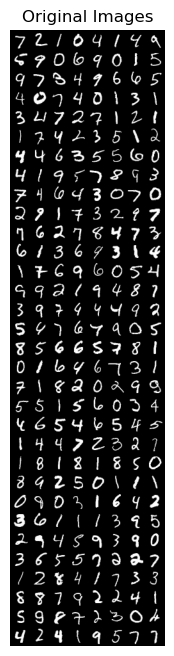

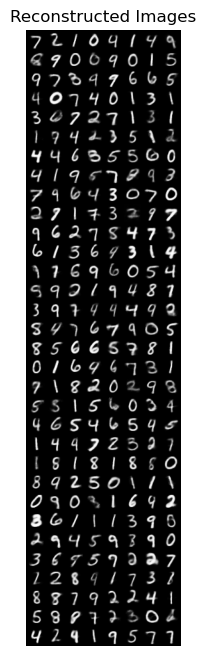

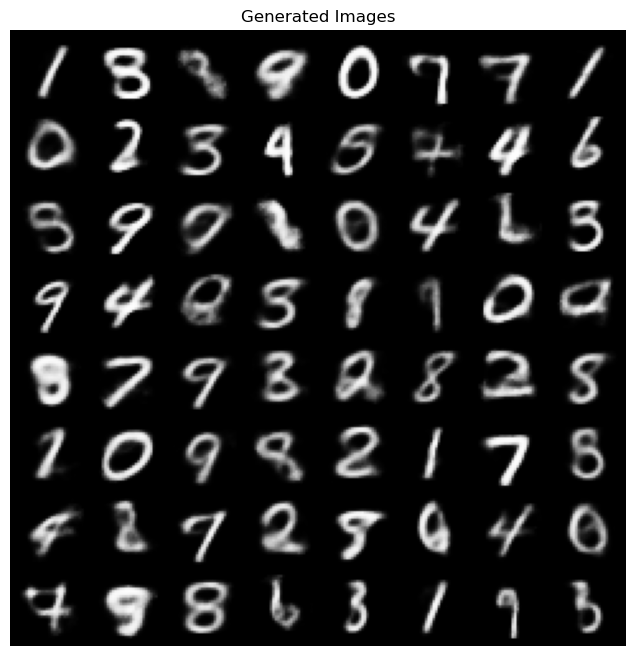

In [7]:
def show_images(images, title):
    images = images.view(-1, 1, 28, 28)
    images = images.cpu().data
    grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon_data, _, _ = model(data)
    # Original Images
    show_images(data, 'Original Images')
    # Reconstructed Images
    show_images(recon_data, 'Reconstructed Images')

    
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    generated_images = model.decode(z)
    show_images(generated_images, 'Generated Images')


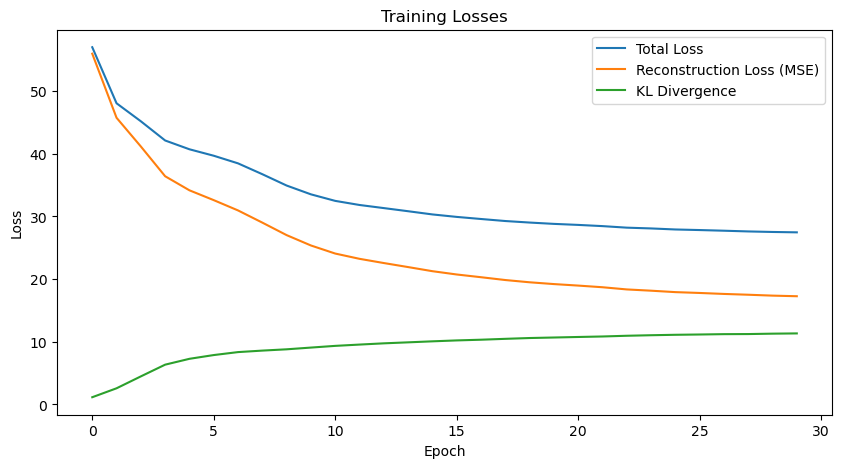

In [8]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Total Loss')
plt.plot(recon_losses, label='Reconstruction Loss (MSE)')
plt.plot(kld_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


In [9]:
# Generate Anomalous Data (Noisy Images)
def add_noise(imgs, noise_factor=0.5):
    noisy_imgs = imgs + noise_factor * torch.randn(*imgs.shape).to(device)
    noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
    return noisy_imgs

# Create noisy test images
data, _ = next(iter(test_loader))
data = data.to(device)
noisy_data = add_noise(data)

In [10]:
# Compute Reconstruction Errors
with torch.no_grad():
    recon_normal, _, _ = model(data)
    recon_anomalous, _, _ = model(noisy_data)
    # Reshape reconstructions to match data shape
    recon_normal = recon_normal.view(-1, 1, 28, 28)
    recon_anomalous = recon_anomalous.view(-1, 1, 28, 28)
    # Reconstruction errors
    recon_error_normal = torch.mean((data - recon_normal) ** 2, dim=[1, 2, 3])
    recon_error_anomalous = torch.mean((noisy_data - recon_anomalous) ** 2, dim=[1, 2, 3])


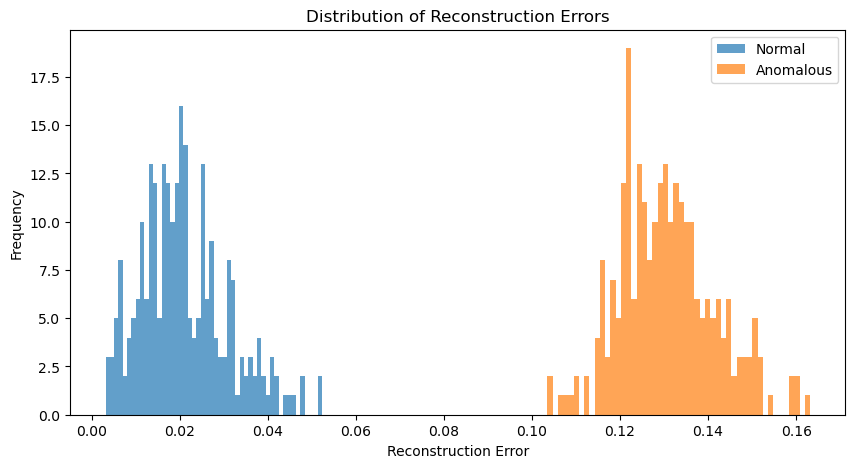

In [11]:
# Plot Distribution of Reconstruction Errors
plt.figure(figsize=(10,5))
plt.hist(recon_error_normal.cpu().numpy(), bins=50, alpha=0.7, label='Normal')
plt.hist(recon_error_anomalous.cpu().numpy(), bins=50, alpha=0.7, label='Anomalous')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Reconstruction Errors')
plt.show()


In [12]:
# Set Threshold and Classify Images
threshold = torch.quantile(recon_error_normal, 0.95).item()
print(f"Anomaly Detection Threshold: {threshold}")

# Classification
normal_labels = recon_error_normal > threshold
anomalous_labels = recon_error_anomalous > threshold

# Detection rates
normal_correct = torch.sum(~normal_labels).item() / len(normal_labels)
anomalous_correct = torch.sum(anomalous_labels).item() / len(anomalous_labels)

print(f"Normal Images Correctly Classified as Normal: {normal_correct*100:.2f}%")
print(f"Anomalous Images Correctly Classified as Anomalous: {anomalous_correct*100:.2f}%")

Anomaly Detection Threshold: 0.039491258561611176
Normal Images Correctly Classified as Normal: 94.92%
Anomalous Images Correctly Classified as Anomalous: 100.00%


In [13]:
latent_dim_2d = 2  # For visualization

model_2d = VAE(hidden_dims=[512, 256], latent_dim=latent_dim_2d).to(device)
optimizer_2d = optim.Adam(model_2d.parameters(), lr=learning_rate)


In [14]:
# Training the model with 2D latent space
train_losses_2d = []
model_2d.train()
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer_2d.zero_grad()
        recon_batch, mu, logvar = model_2d(data)
        loss, _, _ = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        optimizer_2d.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(train_loader.dataset)
    train_losses_2d.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


Epoch [1/30], Loss: 55.3940
Epoch [2/30], Loss: 43.5113
Epoch [3/30], Loss: 41.4187
Epoch [4/30], Loss: 40.2673
Epoch [5/30], Loss: 39.3859
Epoch [6/30], Loss: 38.6943
Epoch [7/30], Loss: 38.0905
Epoch [8/30], Loss: 37.6236
Epoch [9/30], Loss: 37.2195
Epoch [10/30], Loss: 36.8985
Epoch [11/30], Loss: 36.6107
Epoch [12/30], Loss: 36.3341
Epoch [13/30], Loss: 36.1276
Epoch [14/30], Loss: 35.9155
Epoch [15/30], Loss: 35.7604
Epoch [16/30], Loss: 35.5630
Epoch [17/30], Loss: 35.4015
Epoch [18/30], Loss: 35.2815
Epoch [19/30], Loss: 35.1059
Epoch [20/30], Loss: 34.9913
Epoch [21/30], Loss: 34.8776
Epoch [22/30], Loss: 34.7817
Epoch [23/30], Loss: 34.6799
Epoch [24/30], Loss: 34.5789
Epoch [25/30], Loss: 34.4780
Epoch [26/30], Loss: 34.4066
Epoch [27/30], Loss: 34.3068
Epoch [28/30], Loss: 34.2333
Epoch [29/30], Loss: 34.1722
Epoch [30/30], Loss: 34.0797


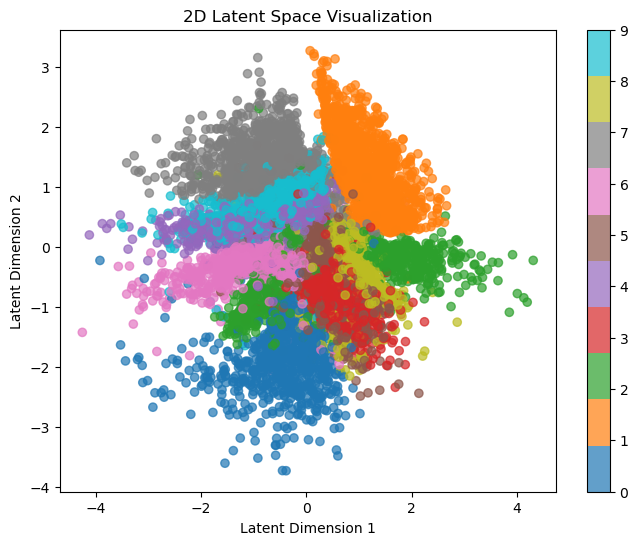

In [15]:
model_2d.eval()
with torch.no_grad():
    all_mu = []
    all_labels = []
    for data, labels in test_loader:
        data = data.to(device)
        mu, _ = model_2d.encode(data.view(-1, 28 * 28))
        all_mu.append(mu.cpu())
        all_labels.append(labels)
    latent_vectors = torch.cat(all_mu)
    labels = torch.cat(all_labels)

# Scatter plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_vectors[:,0], latent_vectors[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.show()
